# Social Network Analysis
This project involves social network analysis based on twitter data. This project helps to better understanding graph analysis methods, as well as different centrality measures in the graph, and edge prediction.

In [ ]:
! pip install networkx
! pip install plotly
! pip install colorlover
! pip install NRCLex

In [ ]:
import networkx as nx
from collections import Counter
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import colorlover as cl
from IPython.display import HTML
import random
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from collections import Counter
import operator
import nltk
import re
from nrclex import NRCLex
nltk.download('punkt')
nltk.download('stopwords')
init_notebook_mode(connected=True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Part 1: Build a mention graph

In [ ]:
df = pd.read_csv("tweets2009-06-0115.csv", sep='\t')
googleTag = df[df["tweet"].str.lower().str.contains("#google", na=False)].copy()

In [ ]:
def addMentionedColumn(df):
    
    def mentionsList(txt):
        allWords = [word.strip(""" ,.:'\";""").lower() for word in txt.split()]
        allNames = [word.strip("@") for word in allWords if word.startswith("@")]
        uniqueNames = list(set(allNames))
        return allNames
    
    df["mentioned"] = df["tweet"].apply(mentionsList)

In [ ]:
def mentionGraph(df):
    g = nx.Graph()
    
    for (index, date, user, tweet, mentionedUsers) in df.itertuples():
        for mentionedUser in mentionedUsers:
            if (user in g) and (mentionedUser in g[user]):
                g[user][mentionedUser]["numberMentions"] += 1
            else:
                g.add_edge(user, mentionedUser, numberMentions=1)
    
    return g

In [ ]:
addMentionedColumn(googleTag)

In [ ]:
googleGraph = mentionGraph(googleTag)

In [ ]:
print("# nodes:", len(googleGraph.nodes()))
print("# edges:", len(googleGraph.edges()))

# nodes: 345
# edges: 308


**The number of nodes in my mention graph is 345 and the number of edges in my mention graph is 308.**

In [ ]:
degrees=nx.degree(googleGraph)

In [ ]:
degree_list=[]
for (user,degree) in degrees:
    degree_list.append(degree)

Text(0.5, 1.0, 'Histogram of degree')

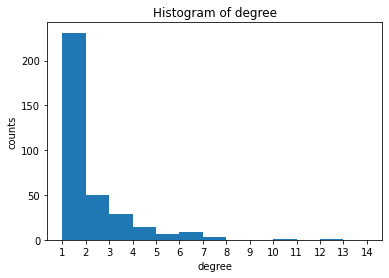

In [ ]:
plt.hist(degree_list,bins=range(1,15))
plt.xlabel('degree')
plt.xticks(range(1,15))
plt.ylabel('counts')
plt.title('Histogram of degree')

**This distribution of node degree shows that most nodes in the network I chose have poor connections, since a large number of nodes are within degree of [1,2), but there are also nodes with very large number of connections [10,11), [12,13).**

In [ ]:
unique, counts = np.unique(degree_list, return_counts=True)

In [ ]:
fraction=np.array([x/sum(counts) for x in counts])

Text(0.5, 1.0, 'Scatter plot of fraction of node in each degree in log scale')

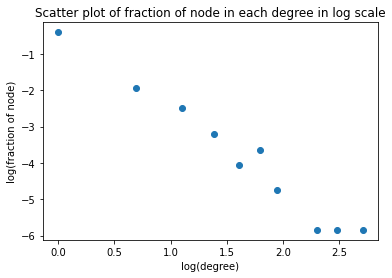

In [ ]:
plt.scatter(np.log(unique),np.log(fraction))
plt.xlabel('log(degree)')
plt.ylabel('log(fraction of node)')
plt.title('Scatter plot of fraction of node in each degree in log scale')

**I think the mention graph shows a power law trend, the points can be fitted by a straight line with negative slope.**

In [ ]:
#Find highest weighted edge
edges=googleGraph.edges(data=True)
max=0
for (n1,n2,weight) in edges:
    if weight['numberMentions']>max:
        max=weight['numberMentions']
        result=(n1,n2,weight)

In [ ]:
result

('extremerushv', 'nymagazine', {'numberMentions': 6})

In [ ]:
#Locate the tweets in the dataframe with this edge
n1_df=googleTag[googleTag['user']=='extremerushv']
index_list=[]
for i in range(len(n1_df)):
    mentioned=n1_df.iloc[i,:]['mentioned']
    if 'nymagazine' in mentioned:
        index_list.append(i)
edge_df=n1_df.iloc[index_list,:]

In [ ]:
edge_df['tweet'].values

array(['@NYMAGAZINE Rated Monkey Bar NY 8.7 I Rate It A Close 9.0 Great New Spot. See More Here: http://is.gd/Jfdu #dining #google #food',
       '@NYMAGAZINE Rated Monkey Bar NY 8.7 I Rate It A Close 9.0 Great New Spot. See More Here: http://is.gd/Jfdu #dining #google #food',
       '@NYMAGAZINE Rated Monkey Bar NY 8.7 I Rate It A Close 9.0 Great New Spot. See More Here: http://is.gd/Jfdu #dining #google #food',
       '@NYMAGAZINE Rated Monkey Bar NY 8.7 I Rate It A Close 9.0 Great New Spot. See More Here: http://is.gd/Jfdu #dining #google #food',
       '@NYMAGAZINE Rated Monkey Bar NY 8.7 I Rate It A Close 9.0 Great New Spot. See More Here: http://is.gd/Jfdu #dining #google #food',
       '@NYMAGAZINE Rated Monkey Bar NY 8.7 I Rate It A Close 9.0 Great New Spot. See More Here: http://is.gd/Jfdu #dining #google #food'],
      dtype=object)

In [ ]:
edge_df['date'].values

array(['2009-06-11 19:40:08', '2009-06-12 01:40:11',
       '2009-06-12 19:40:08', '2009-06-13 01:40:11',
       '2009-06-13 13:40:07', '2009-06-14 19:40:08'], dtype=object)

**This result is quite interesting, the user keeps @NYMAGZINE and tweet the same content on different days but at the same timestamp (19:40:08 and 01:40:11). This is not a natural behavior, maybe there are some errors in the dataset or this user is actually a programmed bot.**

In [ ]:
def plotNetworkSizeColor(graph):
    degreeCentr = nx.degree_centrality(googleGraph)
    maxCentr = np.array(list(nx.degree_centrality(googleGraph).values())).max()
    minCentr = np.array(list(nx.degree_centrality(googleGraph).values())).min()
    
    scatters=[]

    for (node1, node2) in graph.edges():
        x0, y0 = graph.nodes[node1]['pos']
        x1, y1 = graph.nodes[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='none',
                mode='lines', 
                line=scatter.Line(width=edgeWidth ,color='#888'))
        scatters.append(s)



    for node in graph.nodes():
        nodeCentr = degreeCentr[node]
        nodeColor = int(299*(nodeCentr-minCentr)/(maxCentr-minCentr))
        xPos, yPos = graph.nodes[node]['pos']
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                text="User: %s <br> Degree Centrality: %.3f" % (node, nodeCentr),
                hoverinfo='text',
                mode='markers', 
                marker=dict(
                    color=purd300[nodeColor], 
                    size=nx.degree(graph,node)*2,         
                    line=dict(width=2)))
        scatters.append(s)
    
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)

In [ ]:
def addRandomPositions(graph):
    posDict = dict((node,(random.gauss(0,10),random.gauss(0,10))) for node in graph.nodes())
    nx.set_node_attributes(graph, name="pos", values=posDict)

In [ ]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [ ]:
def applyLayout(graph, layoutFunc):
    posDict = layoutFunc(graph) 
    nx.set_node_attributes(graph, name="pos", values=posDict)

In [ ]:
addRandomPositions(googleGraph)
purd = cl.scales['9']['seq']['PuRd']
purd300 = cl.interp(purd, 300)
googleGraphCircular = googleGraph.copy()
applyLayout(googleGraphCircular, nx.circular_layout)
configure_plotly_browser_state()
plotNetworkSizeColor(googleGraphCircular)

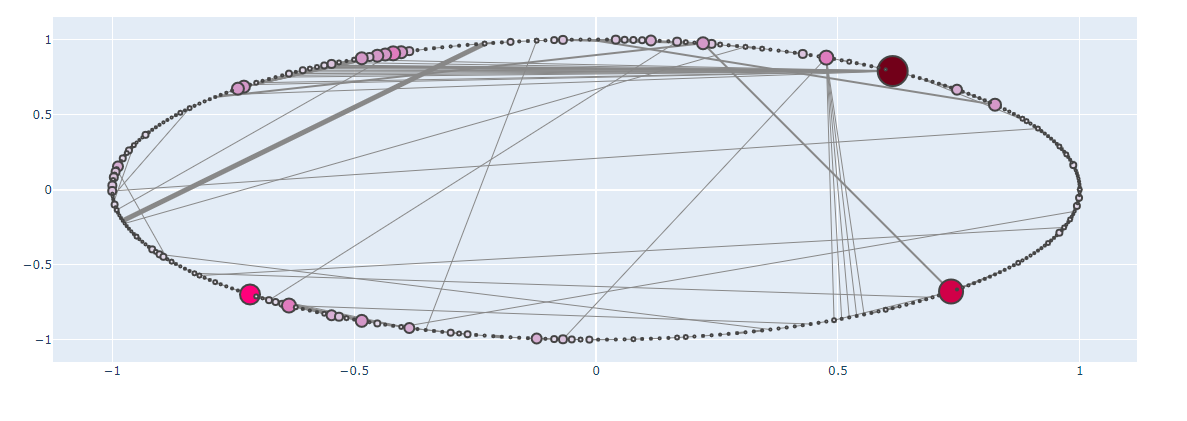

# Part 2: Content analysis

In [ ]:
def get_stop_words():
    stop = set(stopwords.words('english'))
    return stop

In [ ]:
def getTopK(df, kwords):
    stop = get_stop_words()
    counter = Counter()
    tokenizer=RegexpTokenizer(r'\w+')
    tweets=df['tweet'].values
    for tweet in tweets:
        word_list=tokenizer.tokenize(tweet)
        counter.update([word.lower() 
                          for word 
                          in re.findall(r'\w+', tweet) 
                          if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(kwords)
    return topk

In [ ]:
getTopK(googleTag,10)

[('google', 639),
 ('http', 567),
 ('com', 204),
 ('bit', 195),
 ('search', 94),
 ('2009', 82),
 ('tinyurl', 73),
 ('twitter', 69),
 ('bing', 56),
 ('wave', 49)]

**The main themes are about search engine based topics, the most common words contain google, bing, twitter, and some urls.**

In [ ]:
def new_plotNetworkSizeColor(graph):
    degreeCentr = nx.degree_centrality(googleGraph)
    maxCentr = np.array(list(nx.degree_centrality(googleGraph).values())).max()
    minCentr = np.array(list(nx.degree_centrality(googleGraph).values())).min()
    
    scatters=[]

    for (node1, node2) in graph.edges():
        x0, y0 = graph.nodes[node1]['pos']
        x1, y1 = graph.nodes[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='none',
                mode='lines', 
                line=scatter.Line(width=edgeWidth ,color='#888'))
        scatters.append(s)



    for node in graph.nodes():
        users=googleTag['user'].unique()
        if node in users:
            #create a dataframe for the specific user
            node_df=googleTag[googleTag['user']==node]
            #find 3 most common words for the user
            common_words=getTopK(node_df,3)
            nodeCentr = degreeCentr[node]
            nodeColor = int(299*(nodeCentr-minCentr)/(maxCentr-minCentr))
            xPos, yPos = graph.nodes[node]['pos']
            s = Scatter(
                    x=[xPos], 
                    y=[yPos], 
                    text="User: %s <br> Degree Centrality: %.3f Common Words:%s" % (node, nodeCentr,common_words),
                    hoverinfo='text',
                    mode='markers', 
                    marker=dict(
                        color=purd300[nodeColor], 
                        size=nx.degree(graph,node)*2,         
                        line=dict(width=2)))
            scatters.append(s)
        else:
            nodeCentr = degreeCentr[node]
            nodeColor = int(299*(nodeCentr-minCentr)/(maxCentr-minCentr))
            xPos, yPos = graph.nodes[node]['pos']
            s = Scatter(
                    x=[xPos], 
                    y=[yPos], 
                    text="User: %s <br> Degree Centrality: %.3f" % (node, nodeCentr),
                    hoverinfo='text',
                    mode='markers', 
                    marker=dict(
                        color='#888', 
                        size=nx.degree(graph,node)*2,         
                        line=dict(width=2)))
            scatters.append(s)

    
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)

In [ ]:
applyLayout(googleGraphCircular, nx.circular_layout)
configure_plotly_browser_state()
new_plotNetworkSizeColor(googleGraphCircular)

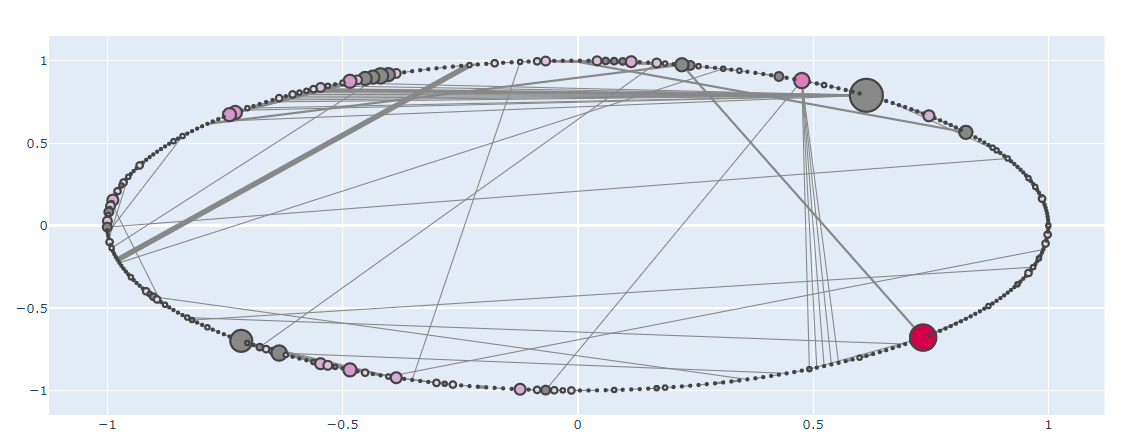

**In the graph above, nodes that have words are in red color and nodes that don't have words are in gray. For nodes with words, the words are similar for connected users.**

# Part 3: Centrality analysis

In [ ]:
pageRank_centrality=nx.pagerank(googleGraph)
eigenvector_centrality=nx.eigenvector_centrality(googleGraph)

In [ ]:
def plotNetworkwithPageRank(graph):
    pageRank_centrality=nx.pagerank(googleGraph)
    maxCentr = np.array(list(nx.pagerank(googleGraph).values())).max()
    minCentr = np.array(list(nx.pagerank(googleGraph).values())).min()
    
    scatters=[]

    for (node1, node2) in graph.edges():
        x0, y0 = graph.nodes[node1]['pos']
        x1, y1 = graph.nodes[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='none',
                mode='lines', 
                line=scatter.Line(width=edgeWidth ,color='#888'))
        scatters.append(s)



    for node in graph.nodes():
        nodeCentr = pageRank_centrality[node]
        nodeColor = int(299*(nodeCentr-minCentr)/(maxCentr-minCentr))
        xPos, yPos = graph.nodes[node]['pos']
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                text="User: %s <br> PageRank: %.3f" % (node, nodeCentr),
                hoverinfo='text',
                mode='markers', 
                marker=dict(
                    color=purd300[nodeColor], 
                    size=pageRank_centrality[node]*1500,         
                    line=dict(width=2)))
        scatters.append(s)
    
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)

In [ ]:
#PageRank Centrality
applyLayout(googleGraphCircular, nx.circular_layout)
configure_plotly_browser_state()
plotNetworkwithPageRank(googleGraphCircular)

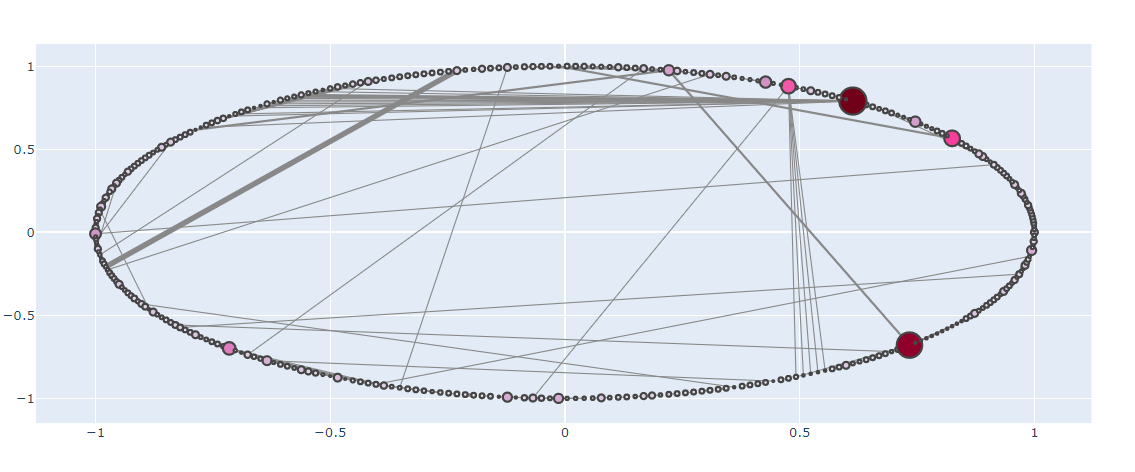

In [ ]:
def plotNetworkwithEigenVector(graph):
    eigenvector_centrality=nx.eigenvector_centrality(googleGraph)
    maxCentr = np.array(list(nx.eigenvector_centrality(googleGraph).values())).max()
    minCentr = np.array(list(nx.eigenvector_centrality(googleGraph).values())).min()
    
    scatters=[]

    for (node1, node2) in graph.edges():
        x0, y0 = graph.nodes[node1]['pos']
        x1, y1 = graph.nodes[node2]['pos']
        edgeWidth = graph[node1][node2]['numberMentions']
        s = Scatter(
                x=[x0, x1],
                y=[y0, y1],
                hoverinfo='none',
                mode='lines', 
                line=scatter.Line(width=edgeWidth ,color='#888'))
        scatters.append(s)



    for node in graph.nodes():
        nodeCentr = eigenvector_centrality[node]
        nodeColor = int(299*(nodeCentr-minCentr)/(maxCentr-minCentr))
        xPos, yPos = graph.nodes[node]['pos']
        s = Scatter(
                x=[xPos], 
                y=[yPos], 
                text="User: %s <br> EigenVector Centrality: %.3f" % (node, nodeCentr),
                hoverinfo='text',
                mode='markers', 
                marker=dict(
                    color=purd300[nodeColor], 
                    size=eigenvector_centrality[node]*50,         
                    line=dict(width=2)))
        scatters.append(s)
    
    layout = Layout(showlegend=False)
    fig = Figure(data=scatters, layout=layout)
    iplot(fig, show_link=False)

In [ ]:
#EigenVector Centrality
applyLayout(googleGraphCircular, nx.circular_layout)
configure_plotly_browser_state()
plotNetworkwithEigenVector(googleGraphCircular)

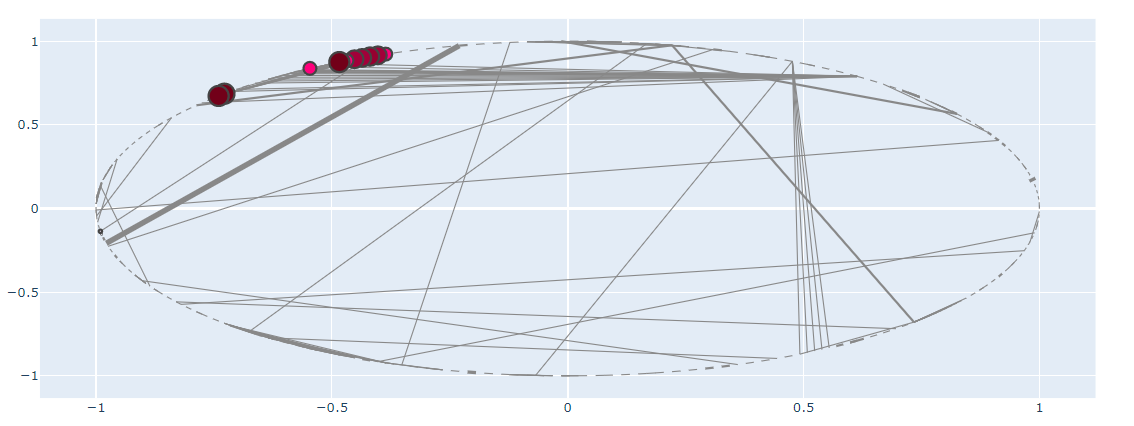

**5 most central nodes for PageRank: 'brunoswell', 'stefanw', 'problogger', 'mmidas', 'cheth'.**

**5 most central nodes for Eigenvector Centrality: 'nmallin', 'mpilatow', 'mcancino', 'google', 'yahoo'.**

1.   The results between two centrality measures are quite different. Eigenvector centrality calculate centrality based on the importance of its neighbors and pagerank calculate a ranking for each node based on the incoming link, in undirected graph each edge will be treated as a two-way directed edge. Eigenvecotr centrality values more on the quality of each node's neighbor but pagerank values the number of connections of each node and the difference in nature of these two measures causes the difference in result.
2.   I think eigenvector centrality measure produced a  more meaningful interpretation in this case, since the graph I'm using is undirected and simply treat each edge as two-way directed is a bad assumption for the structure of this network, since from my observation, a lot of edges are actually one-way directed.



# Part 4: Sentiment analysis

In [ ]:
emotion_dict={}
for index, tweet_data in googleTag.iterrows():
  tweet = tweet_data['tweet']
  text_object = NRCLex(tweet)
  absolute_numbers = text_object.raw_emotion_scores
  if absolute_numbers:
      for (emotion,num) in absolute_numbers.items():
          if emotion not in emotion_dict.keys():
              emotion_dict[emotion]=0
          emotion_dict[emotion]+=num


Text(0.5, 1.0, 'Bar plot of Number of words in each emotion')

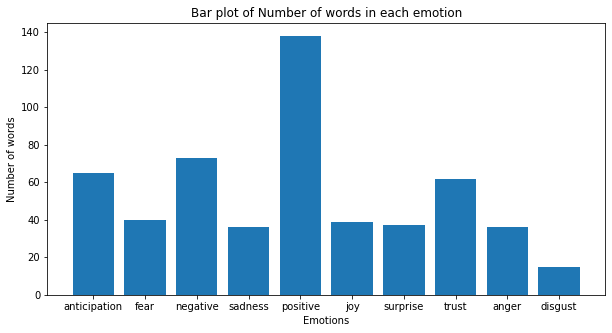

In [ ]:
keys=emotion_dict.keys()
values=emotion_dict.values()
fig=plt.figure(figsize=(10,5))
plt.bar(keys,values)
plt.xlabel('Emotions')
plt.ylabel('Number of words')
plt.title('Bar plot of Number of words in each emotion')

**Positive is the most frequent in the data and I don't think it makes sense in the context of my hash-tag. First of all, a lot of tweets with hash-tag of google aren't actually talking about google-related topics, like this one: *The Best Time to post on Twitter - http://bit.ly/2jXZ17 #twitter #seo #news #jobs #google #facebook #facts (via @NewcastleWEB)*, also the positive term 'best' is not actually a positive emotion related to this hash-tag. There are some tweets which don't have positive emotion but are treated as positive, for example: *Dear Google, may I have a full status bar for Chrome please, or an option. Till then I can't really use it to work on #google #chrome*.**




In [ ]:
count_dict={}
users=googleTag['user'].unique()
for user in users:
    user_df=googleTag[googleTag['user']==user]
    count_dict[user]={}
    n=len(user_df)
    for index, tweet_data in user_df.iterrows():
        tweet = str(user_df['tweet'])
        text_object = NRCLex(tweet)
        relative_numbers = text_object.raw_emotion_scores
        for (affect,num) in relative_numbers.items():
            if affect=='anticip':
                affect='anticipation'
            if affect not in count_dict[user].keys():
                count_dict[user][affect]=0
            count_dict[user][affect]+=num


In [ ]:
fraction_dict={}
for user in count_dict.keys():
    n=0
    for (affect,count) in count_dict[user].items():
        n+=count
    fraction_dict[user]={}
    for (affect,count) in count_dict[user].items():
        fraction_dict[user][affect]=count/n



In [ ]:
affect_df=pd.DataFrame(fraction_dict)
max_users=affect_df.idxmax(axis=1)
affect_user_df=pd.DataFrame(max_users)
affect_user_df.columns=['user name']
affect_user_df

,user name
anticipation,charltonb
fear,einfachtoll
negative,midtoad
sadness,bnettechnology
joy,googleqsb
positive,ebrito
surprise,losebellyfatnow
trust,mdee14
anger,stefane_
disgust,337studios


In [ ]:
affects=list(affect_df.index)
intersection_users=set(list(users)).intersection(pageRank_centrality.keys())
centrality_dict=dict((k, pageRank_centrality[k]) for k in intersection_users)
affect_dict=dict((k, fraction_dict[k]) for k in intersection_users)

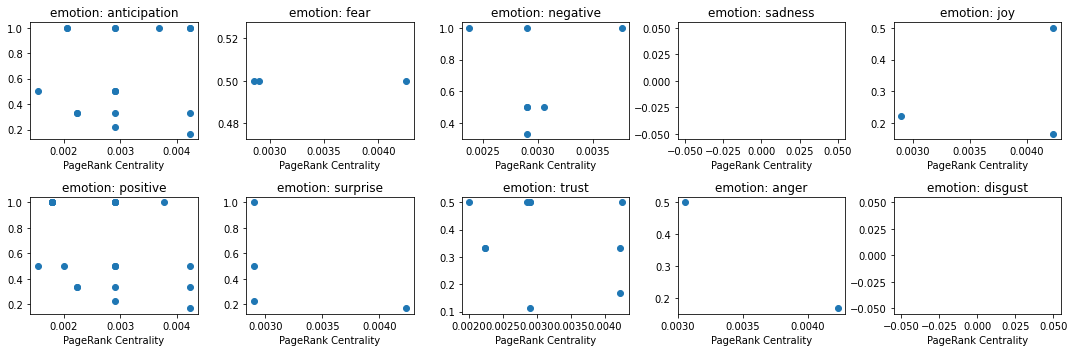

In [ ]:
fig,axes=plt.subplots(2,5,figsize=(15,5))
ax=axes.ravel()
centrality_list=list(centrality_dict.values())
for i in range(10):
    affect=affects[i]
    affect_list=[]
    for user in intersection_users:
        affect_list.append(affect_df.loc[affect,user])
    ax[i].scatter(centrality_list,affect_list,label=affect)
    ax[i].set_xlabel('PageRank Centrality')
    ax[i].set_title('emotion: {}'.format(affect))
plt.tight_layout()


In [ ]:
affects=list(affect_df.index)
intersection_users=set(list(users)).intersection(eigenvector_centrality.keys())
centrality_dict=dict((k, eigenvector_centrality[k]) for k in intersection_users)
affect_dict=dict((k, fraction_dict[k]) for k in intersection_users)

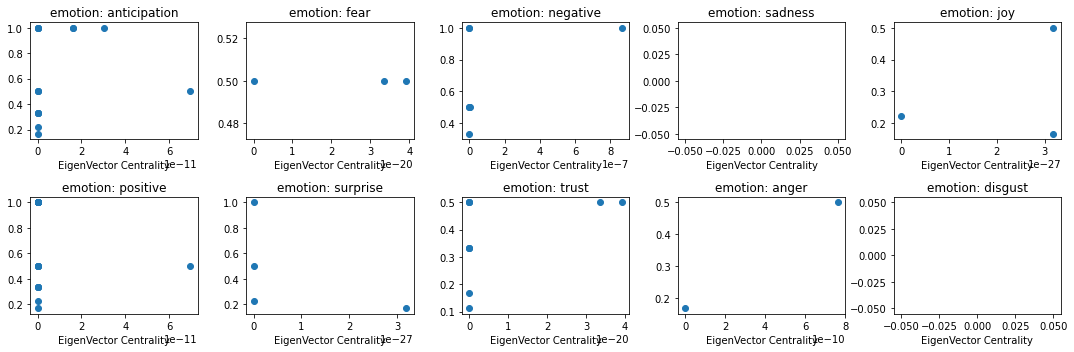

In [ ]:
fig,axes=plt.subplots(2,5,figsize=(15,5))
ax=axes.ravel()
centrality_list=list(centrality_dict.values())
for i in range(10):
    affect=affects[i]
    affect_list=[]
    for user in intersection_users:
        affect_list.append(affect_df.loc[affect,user])
    ax[i].scatter(centrality_list,affect_list,label=affect)
    ax[i].set_xlabel('EigenVector Centrality')
    ax[i].set_title('emotion: {}'.format(affect))
plt.tight_layout()

**From these plots, it is clear that dimensions of the emotianl affect have no correlation with pagerank centrality or eigenvector centrality. I think the reason might be that most of the tweets with hashtag 'google' are used to spread information or used for advertising purpose rather than expressing personal thoughts, therefore it is less likely for those tweets to have obvious emotion.**